#Reddit Data Analysis

In [1]:
import pandas as pd
import numpy as np
from utils import *
import matplotlib  
import matplotlib.pyplot as plt  
#Inline Plotting for Ipython Notebook 
%matplotlib inline 
#https://bigquery.cloud.google.com/table/fh-bigquery:reddit_posts.full_corpus_201509

###First Query

In [2]:

df=pd.io.gbq.read_gbq("""  
SELECT DATE(SEC_TO_TIMESTAMP(created)) date_submission,
COUNT(*) as num_submissions
FROM [fh-bigquery:reddit_posts.full_corpus_201509]
GROUP BY date_submission
ORDER by date_submission
""", project_id='fair-future-103511')
df.tail()

Waiting on bqjob_r77782f1f_00000150b8ddcb7c_1 ... (0s) Current status: DONE   


,date_submission,num_submissions
2979,2015-08-28,206100
2980,2015-08-29,180039
2981,2015-08-30,183686
2982,2015-08-31,214685
2983,2015-09-01,10299


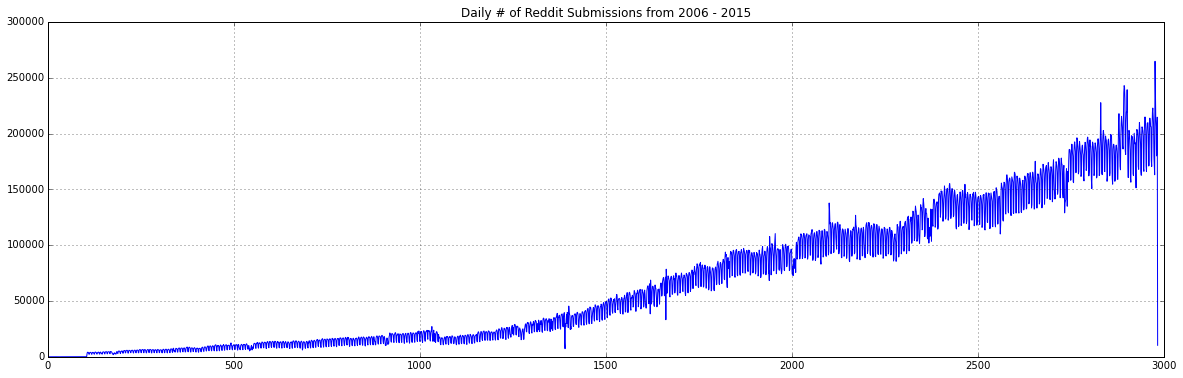

In [3]:
df['num_submissions'].plot(title='Daily # of Reddit Submissions from 2006 - 2015', figsize=(20,6))

###Best Time To Post - Heatmap

In [4]:
df=pd.io.gbq.read_gbq("""  
SELECT DATE(SEC_TO_TIMESTAMP(created)) date_submission,
COUNT(*) as num_submissions
FROM [fh-bigquery:reddit_posts.full_corpus_201509]
GROUP BY date_submission
ORDER by num_submissions
""", project_id='fair-future-103511')
df.tail(5)

Waiting on bqjob_r4dffc40b_00000150b8dde84c_2 ... (0s) Current status: DONE   


,date_submission,num_submissions
2979,2015-06-02,236465
2980,2015-06-11,239298
2981,2015-06-04,241475
2982,2015-06-03,242973
2983,2015-08-25,264787


In [5]:
df=pd.io.gbq.read_gbq("""  
SELECT DAYOFWEEK(SEC_TO_TIMESTAMP(created - 60*60*5)) as sub_dayofweek,
  HOUR(SEC_TO_TIMESTAMP(created - 60*60*5)) as sub_hour,
  SUM(IF(score >= 3000, 1, 0)) as num_gte_3000,
FROM [fh-bigquery:reddit_posts.full_corpus_201509]
GROUP BY sub_dayofweek, sub_hour
ORDER BY sub_dayofweek, sub_hour
""", project_id='fair-future-103511')


Waiting on bqjob_r29f9e81c_00000150b8ddf441_3 ... (0s) Current status: DONE   


In [6]:
week_hour=df
hour_week_group = week_hour[['num_gte_3000']].groupby([week_hour.sub_hour, week_hour.sub_dayofweek]).sum().reset_index()

week_hour_count = hour_week_group.pivot(index='sub_dayofweek', columns='sub_hour', values='num_gte_3000')


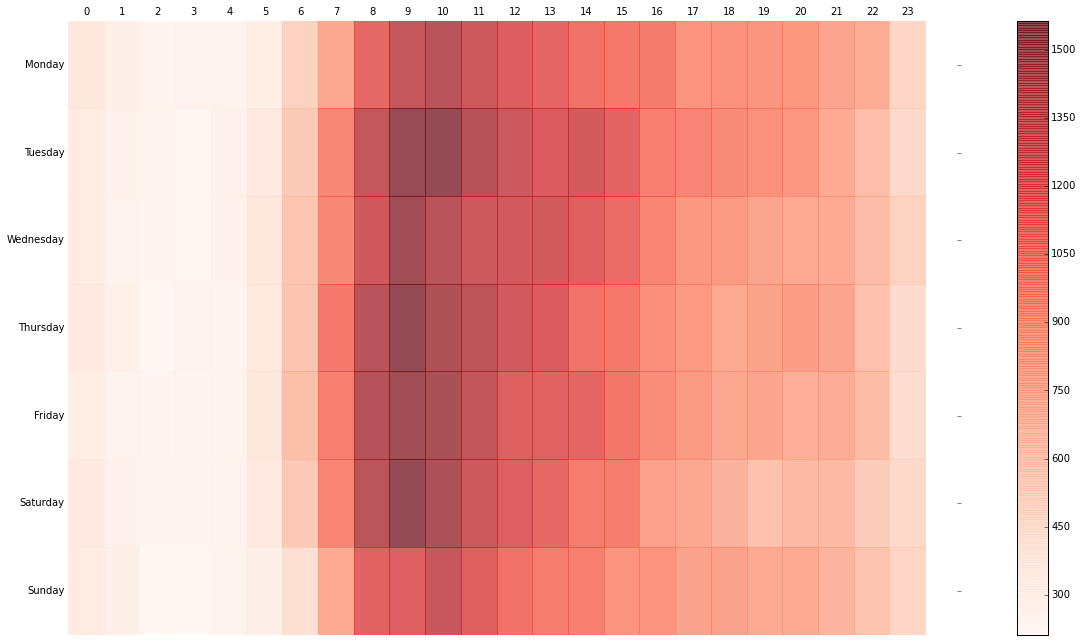

In [7]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(week_hour_count, cmap=plt.cm.Reds, alpha=0.7)
nba_norm = (week_hour_count - week_hour_count.mean()) / (week_hour_count.max() - week_hour_count.min())
nba_sort = nba_norm.sort(ascending=True)

#fig = plt.figure(figsize(13,6), dpi=1600)
fig = plt.gcf()
fig.set_size_inches(20,11)

# turn off the frame
ax.set_frame_on(False)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(nba_sort.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(nba_sort.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# labels for the y-axis
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# note I could have used nba_sort.columns but made "labels" instead
ax.set_xticklabels(nba_sort.columns, minor=False) 
ax.set_yticklabels(labels, minor=False)

# rotate the hour ticks 0/(90deg)
plt.xticks(rotation=0)
ax.grid(False)

# Turn off all the ticks
ax = plt.gca()
plt.colorbar(heatmap)

for t in ax.xaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
for t in ax.yaxis.get_major_ticks(): 
    t.tick1On = False 

In [8]:
sum(df.num_gte_3000)

136553

#Monthly Active Users

In [9]:
df=pd.io.gbq.read_gbq("""  
SELECT subreddit, date, unique_authors FROM
(SELECT subreddit, date, unique_authors, ROW_NUMBER() OVER (PARTITION BY date ORDER BY unique_authors DESC) rank FROM
(SELECT subreddit, LEFT(DATE(SEC_TO_TIMESTAMP(created_utc)), 7) as date, COUNT(UNIQUE(author)) as unique_authors
FROM TABLE_QUERY([fh-bigquery:reddit_comments], \"table_id CONTAINS \'20\' AND LENGTH(table_id)<8\")
GROUP EACH BY subreddit, date
))
WHERE rank <= 20
ORDER BY date ASC, unique_authors DESC""", project_id='fair-future-103511')
df.tail(5)

Waiting on bqjob_r5eae3a90_00000150b8e0a541_4 ... (16s) Current status: DONE   


,subreddit,date,unique_authors
1915,aww,2015-09,70191
1916,explainlikeimfive,2015-09,59300
1917,mildlyinteresting,2015-09,57237
1918,IAmA,2015-09,57197
1919,DestinyTheGame,2015-09,56471


In [11]:
df.head(5)

,subreddit,date,unique_authors
0,reddit.com,2007-10,8370
1,politics,2007-10,3162
2,programming,2007-10,2643
3,science,2007-10,1898
4,entertainment,2007-10,254
